In [3]:
# Compare RAG evaluation results from src/eval/output

import os
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure plots display nicely in the notebook
sns.set(style="whitegrid")



In [4]:
PROJECT_ROOT = Path("..").resolve()
EVAL_OUTPUT_DIR = PROJECT_ROOT / "src" / "eval" / "output"

print("Eval output directory:", EVAL_OUTPUT_DIR)

# List all CSV files in the eval output directory
csv_files = sorted(EVAL_OUTPUT_DIR.glob("*.csv"))

if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {EVAL_OUTPUT_DIR}")

print("Found CSV files:")
for f in csv_files:
    print(" -", f.name)



Eval output directory: /Users/nagendrai/Projects/Prototypes/smart_rfp/src/eval/output
Found CSV files:
 - eval_results_basic_rag.csv
 - eval_results_custom_rag1.csv
 - eval_results_custom_rag2.csv


In [5]:
# Load all evaluation CSVs into a single DataFrame with a model/version label
frames = []
for f in csv_files:
    # Use file name (without extension) as the model/version label
    model_name = f.stem
    df = pd.read_csv(f)
    df["model"] = model_name
    print(model_name, " loaded with shape:", df.shape)
    frames.append(df)

all_results = pd.concat(frames, ignore_index=True)

print("Columns in combined dataframe:")
print(all_results.columns.tolist())

all_results.head()

eval_results_basic_rag  loaded with shape: (5, 12)
eval_results_custom_rag1  loaded with shape: (20, 13)
eval_results_custom_rag2  loaded with shape: (5, 12)
Columns in combined dataframe:
['row_index', 'Prompt', 'Response', 'rag_answer', 'eval_time_sec', 'Faithfulness', 'Context Recall', 'Answer Relevancy', 'Factual Correctness', 'Semantic Similarity', 'BLEU', 'model', 'error']


,row_index,Prompt,Response,rag_answer,eval_time_sec,Faithfulness,Context Recall,Answer Relevancy,Factual Correctness,Semantic Similarity,BLEU,model,error
0,0,Are there contradictions between the scope of ...,The RFP defines scope of works in two places. ...,Upon reviewing the provided sections of the RF...,72.19,0.636364,0.250000,0.000000,0.43,0.605784,0.054065,eval_results_basic_rag,NaN
1,1,Do the guaranteed losses mentioned in differen...,Guaranteed losses are mentioned in multiple pl...,"Upon analyzing the given context, I found that...",46.68,0.666667,0.333333,0.758477,0.57,0.644928,0.049821,eval_results_basic_rag,NaN
2,2,Summarize the process for evaluating technical...,RFP specifies that technical bids are evaluate...,"Based on the provided context, the process for...",64.82,0.777778,1.000000,0.909859,0.33,0.659528,0.133084,eval_results_basic_rag,NaN
3,3,List risks associated with civil and structura...,"Risks include unclear scope boundaries, depend...","Based on the provided RFP document, the follow...",75.95,0.470588,0.500000,0.900008,0.25,0.627245,0.028630,eval_results_basic_rag,NaN
4,4,Extract line items from the Data Requirement S...,"The DRS includes items such as cabling, switch...","Based on the provided context, the following l...",58.78,1.000000,0.000000,0.828286,0.17,0.681956,0.037879,eval_results_basic_rag,NaN


In [6]:
# Aggregate comparison of key metrics across models

# Select metric columns that exist in the combined dataframe
candidate_metric_cols = [
    "Faithfulness",
    "Context Recall",
    "Answer Relevancy",
    "Factual Correctness",
    "Semantic Similarity",
    "BLEU",
]

metric_cols = [c for c in candidate_metric_cols if c in all_results.columns]

if not metric_cols:
    raise ValueError("No expected metric columns found in the evaluation results.")

print("Metrics used for comparison:", metric_cols)



Metrics used for comparison: ['Faithfulness', 'Context Recall', 'Answer Relevancy', 'Factual Correctness', 'Semantic Similarity', 'BLEU']


In [7]:
# Compute mean metrics per model
model_summary = (
    all_results
    .groupby("model", as_index=False)[metric_cols]
    .mean()
)

print("\nAverage metrics per model:")
display(model_summary)




Average metrics per model:


,model,Faithfulness,Context Recall,Answer Relevancy,Factual Correctness,Semantic Similarity,BLEU
0,eval_results_basic_rag,0.710279,0.416667,0.679326,0.350,0.643888,0.060696
1,eval_results_custom_rag1,0.803419,0.333333,0.791451,0.165,0.643255,0.075195
2,eval_results_custom_rag2,0.760171,0.466667,0.851672,0.230,0.643879,0.043665


/var/folders/z7/j2qbbk9n439_7v22jhrg6c3h0000gn/T/ipykernel_4710/3941220530.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
/var/folders/z7/j2qbbk9n439_7v22jhrg6c3h0000gn/T/ipykernel_4710/3941220530.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
/var/folders/z7/j2qbbk9n439_7v22jhrg6c3h0000gn/T/ipykernel_4710/3941220530.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
/var/folders/z7/j2qbbk9n439_7v22jhrg6c3h0000gn/T/ipykernel_4710/3941220530.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e.

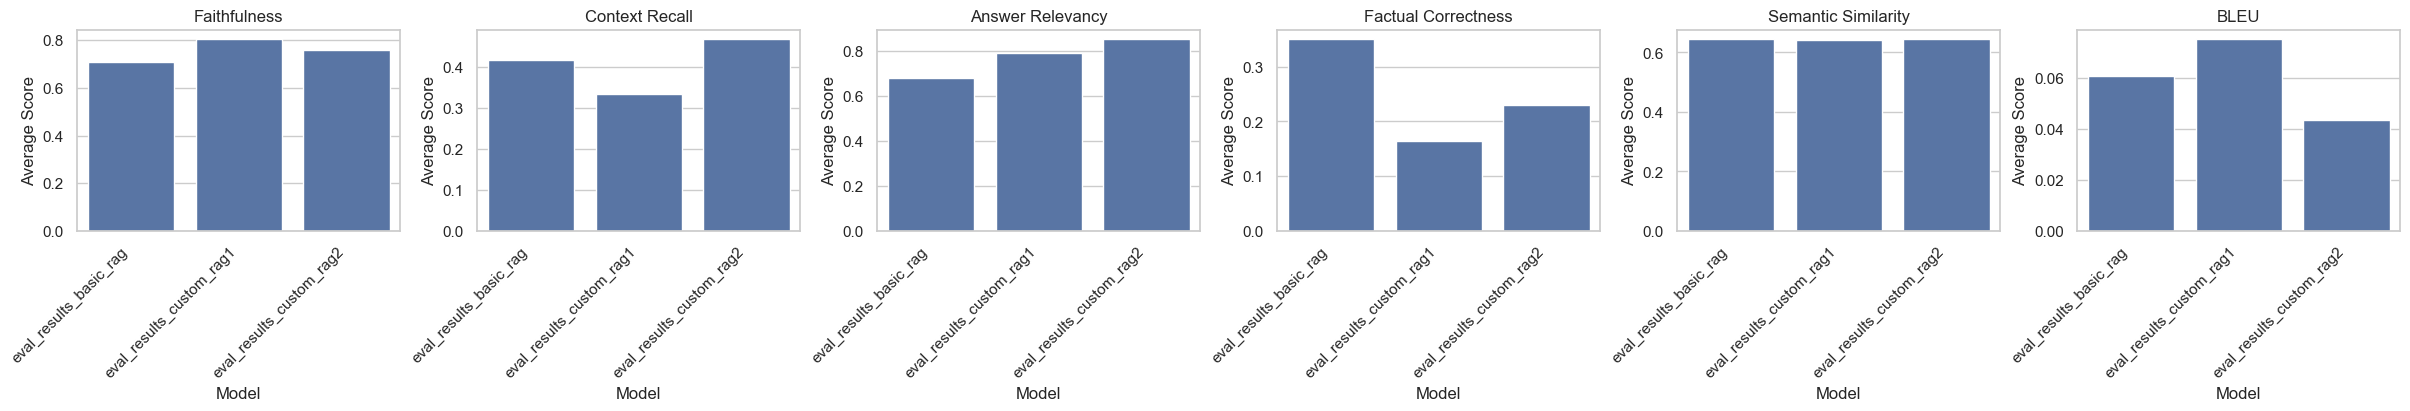

In [8]:
# Plot bar charts comparing models for each metric
num_metrics = len(metric_cols)
fig, axes = plt.subplots(1, num_metrics, figsize=(4 * num_metrics, 4), constrained_layout=True)

if num_metrics == 1:
    axes = [axes]

for ax, metric in zip(axes, metric_cols):
    sns.barplot(data=model_summary, x="model", y=metric, ax=ax)
    ax.set_title(metric)
    ax.set_xlabel("Model")
    ax.set_ylabel("Average Score")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt.show()


In [9]:

# Optional: show per-prompt side‑by‑side comparison for inspection
print("\nSample per‑prompt comparison (first 10 rows):")
cols_to_show = ["row_index", "Prompt", "model"] + metric_cols
per_prompt_sample = (
    all_results[cols_to_show]
    .sort_values(["row_index", "model"])
    .head(20)
)

display(per_prompt_sample)


Sample per‑prompt comparison (first 10 rows):


,row_index,Prompt,model,Faithfulness,Context Recall,Answer Relevancy,Factual Correctness,Semantic Similarity,BLEU
0,0,Are there contradictions between the scope of ...,eval_results_basic_rag,0.636364,0.250000,0.000000,0.43,0.605784,0.054065
5,0,Are there contradictions between the scope of ...,eval_results_custom_rag1,1.000000,1.000000,0.605417,0.19,0.621253,0.109349
25,0,Are there contradictions between the scope of ...,eval_results_custom_rag2,0.500000,0.500000,0.837676,0.31,0.607716,0.033879
1,1,Do the guaranteed losses mentioned in differen...,eval_results_basic_rag,0.666667,0.333333,0.758477,0.57,0.644928,0.049821
6,1,Do the guaranteed losses mentioned in differen...,eval_results_custom_rag1,0.777778,0.333333,0.757840,0.33,0.684798,0.023509
26,1,Do the guaranteed losses mentioned in differen...,eval_results_custom_rag2,0.600000,0.333333,0.717044,0.36,0.696493,0.012867
2,2,Summarize the process for evaluating technical...,eval_results_basic_rag,0.777778,1.000000,0.909859,0.33,0.659528,0.133084
7,2,Summarize the process for evaluating technical...,eval_results_custom_rag1,0.769231,0.000000,0.896499,0.00,0.670295,0.139291
27,2,Summarize the process for evaluating technical...,eval_results_custom_rag2,0.923077,1.000000,0.909859,0.18,0.666798,0.153358
3,3,List risks associated with civil and structura...,eval_results_basic_rag,0.470588,0.500000,0.900008,0.25,0.627245,0.028630
